In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, Sequential, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras_radam import RAdam

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Dot Product with RMSE loss function

In [2]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [3]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


In [4]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

In [5]:
# normalization

# pop_ratings = ratinprefs = pop_ratings['rating']gs[ratings['movie_id'].isin((rating_counts).index[0:500])]
pop_ratings = ratings.set_index(['movie_id', 'user_id'])

prefs = pop_ratings['rating']

mean_0 = prefs.mean() # global mean
prefs = prefs - mean_0

mean_i = prefs.groupby("movie_id").mean() # item mean
prefs = prefs - mean_i

mean_u = prefs.groupby(['user_id']).mean() # user mean
prefs = prefs - mean_u

prefs = prefs.reset_index()

In [6]:
prefs

,movie_id,user_id,rating
0,1,44,0.441303
1,1,61,-0.828520
2,1,67,1.005327
3,1,72,-0.446089
4,1,86,1.303265
...,...,...,...
1176947,1000,9990,0.292686
1176948,1000,9992,1.274889
1176949,1000,9994,-0.741606
1176950,1000,9997,0.664086


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.1, random_state=42)

In [8]:
test.head()

,user_id,movie_id,rating
904556,5062,706,2
171326,9044,148,4
190893,1736,169,4
1082109,5270,877,1
881877,6100,691,4


In [9]:
# https://www.kdnuggets.com/2019/07/building-recommender-system-part-2.html

In [10]:
from keras import losses
from keras.utils import to_categorical
from keras import backend
from keras.regularizers import l2

K = 25; 

#creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, K, name="Movie-Embedding", embeddings_regularizer=l2(1e-6))(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, K, name="User-Embedding", embeddings_regularizer=l2(1e-6))(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile(loss='mean_squared_error', optimizer=RAdam(), metrics=['accuracy'])

# Optimizer : 'adam', RAdam(), 'sgd'
# Loss = 'categorical_crossentropy', 'mean_squared_error'

Epoch 1/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 0.8819 - accuracy: 0.4088
Epoch 2/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 0.8642 - accuracy: 0.4151
Epoch 3/20
1059256/1059256 [==============================] - 10s 10us/step - loss: 0.8476 - accuracy: 0.4209
Epoch 4/20
1059256/1059256 [==============================] - 7s 7us/step - loss: 0.8321 - accuracy: 0.4269
Epoch 5/20
1059256/1059256 [==============================] - 7s 7us/step - loss: 0.8185 - accuracy: 0.4320
Epoch 6/20
1059256/1059256 [==============================] - 9s 9us/step - loss: 0.8064 - accuracy: 0.4366
Epoch 7/20
1059256/1059256 [==============================] - 9s 8us/step - loss: 0.7959 - accuracy: 0.4410
Epoch 8/20
1059256/1059256 [==============================] - 9s 8us/step - loss: 0.7869 - accuracy: 0.4444
Epoch 9/20
1059256/1059256 [==============================] - 8s 8us/step - loss: 0.7791 - accuracy: 0.4481
Epoch 10/20
1059256/1059

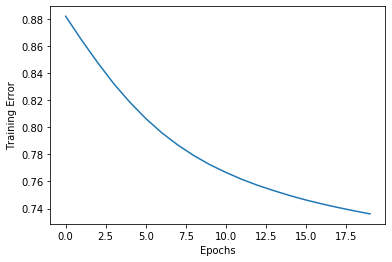

In [17]:
if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.movie_id], train.rating, batch_size=1000, epochs=20, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [18]:
model.evaluate([test.user_id, test.movie_id], test.rating)

117696/117696 [==============================] - 3s 28us/step


[1.2104513522413776, 0.3689165413379669]

In [19]:
pred = model.predict([test.user_id.head(10), test.movie_id.head(10)])

[print(pred[i], test.rating.iloc[i]) for i in range(0,10)]

[4.017096] 2
[4.092745] 4
[3.918302] 4
[3.1383307] 1
[4.3099527] 4
[4.7526994] 4
[3.5820968] 5
[4.2566257] 4
[4.4032836] 4
[5.359527] 5


[None, None, None, None, None, None, None, None, None, None]

In [20]:
pred = model.predict([samples.user_id, samples.movie_id])

In [21]:
pop_samples = samples.set_index(['movie_id', 'user_id'])

pred = pop_samples['rating']

pred = pred + mean_u
pred = pred + mean_i
pred = pred + mean_0

prediction = pred.reset_index()

pred = (prediction['rating']).to_numpy()

In [22]:
np.asarray(pred)

array([6.38990903, 6.08572517, 6.81388785, ..., 6.12030204, 6.19113942,
       6.85188095])

In [37]:
for i in range(pred.shape[0]):
    pred[i] = np.round(pred[i])
    if (pred[i] < 1):
        pred[i] = 1
    elif (pred[i] > 5):
        pred[i] = 5

In [38]:
pred

array([[3.],
       [3.],
       [3.],
       ...,
       [3.],
       [3.],
       [4.]], dtype=float32)

In [39]:
submission = load_data(DATA_TEST_PATH)
submission['rating'] = pred
submission

,user_id,movie_id,rating
0,37,1,3.0
1,73,1,3.0
2,156,1,3.0
3,160,1,3.0
4,248,1,4.0
...,...,...,...
1176947,9974,1000,4.0
1176948,9977,1000,4.0
1176949,9978,1000,3.0
1176950,9982,1000,3.0


In [40]:
from helpers import create_csv

DATA_SUBMISSION = "data/submission_dotprodRMSEnorm.csv"
create_csv(DATA_SUBMISSION, submission)

Dot Product with RMSE using librairies : pandas and keras - AICrowd : RMSE = .... ; Secondary = ....

In [ ]:
## Problems : the prediction has 6. ... 